# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                
Sample_029  P10721;P10721-2                                                  16.494
Sample_187  C9JP35                                                           17.538
Sample_127  D6RJG0;Q9Y6N8                                                    16.123
Sample_040  A0A0G2JMC9;A0A0G2JMW8;A8MZH0;Q8N149;Q8N149-2;Q8N149-3;Q8N149-4   10.629
Sample_051  J3KNA1;Q12840                                                    20.935
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups
Sample_056  O76070           14.089
Sample_038  Q9NY15           15.043
Sample_137  F2Z2C8;Q9BVH7    13.571
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.672
            A0A075B6Q5                 13.011
            A0A075B6R2                 13.739
            A0A075B6S5                 13.417
            A0A087WSY4                 12.306
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.543
            Q9UI40;Q9UI40-2            13.227
            Q9UIW2                     12.073
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.727
            Q9UP79                     12.606
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.806,15.050,16.842,19.863,16.056,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.744,19.067,...,15.528,15.576,14.404,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.992,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.839,17.705,17.039,15.733,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.787,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.249,15.345,17.084,18.708,14.249,19.433,11.735,10.652
Sample_207,15.739,16.877,15.469,16.898,12.926,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.672,...,16.012,15.178,12.711,15.050,16.842,19.863,11.810,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.106,19.067,16.188,...,15.528,15.576,13.939,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.751,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.939,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.922,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.998,15.345,17.084,18.708,14.249,19.433,13.204,11.321
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 318.98it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.16it/s]

100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.97it/s]

100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.97it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.18it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.02it/s]

100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.17it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.64it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.39it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.45it/s]

100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.65it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.91it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.57it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.62it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.57it/s]

100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.45it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.95it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.52it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.51it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.54it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.41it/s]

100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

100%|██████████| 8/8 [00:03<00:00,  2.63it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.14it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.76it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.84it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.45it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.31it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.27it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.32it/s]

100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.66it/s]

 30%|███       | 3/10 [00:00<00:01,  4.43it/s]

 40%|████      | 4/10 [00:00<00:01,  3.95it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.89it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.46it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.22it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.29it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.42it/s]

100%|██████████| 10/10 [00:03<00:00,  2.48it/s]

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.72it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.57it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.17it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.51it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.21it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.85it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.48it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.33it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.36it/s]

100%|██████████| 11/11 [00:03<00:00,  2.52it/s]

100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.71it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.20it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.73it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.59it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.51it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.38it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.11it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.45it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.20it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.26it/s]

100%|██████████| 12/12 [00:04<00:00,  2.40it/s]

100%|██████████| 12/12 [00:04<00:00,  2.85it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.65it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.86it/s]

 31%|███       | 4/13 [00:00<00:02,  4.20it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.86it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.54it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.47it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.39it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.32it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.91it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.50it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.20it/s]

100%|██████████| 13/13 [00:04<00:00,  2.12it/s]

100%|██████████| 13/13 [00:04<00:00,  2.89it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.70it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.24it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.77it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.61it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.36it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.34it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.36it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.35it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.00it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.94it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.68it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.32it/s]

100%|██████████| 14/14 [00:04<00:00,  2.14it/s]

100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.39it/s]

 20%|██        | 3/15 [00:00<00:02,  4.73it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.10it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.83it/s]

 40%|████      | 6/15 [00:01<00:02,  3.68it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.44it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.37it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.37it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.36it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.27it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.98it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.95it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.50it/s]

100%|██████████| 15/15 [00:04<00:00,  2.35it/s]

100%|██████████| 15/15 [00:04<00:00,  3.10it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.063 0.027          0.711 0.396       0.103   
2             0.004 0.003      0.056 0.019          0.687 0.088       0.624   
3             0.005 0.004      0.071 0.024          0.765 0.101       0.720   
4             0.004 0.000      0.051 0.017          0.769 0.096       0.762   
5             0.005 0.005      0.061 0.023          0.765 0.097       0.760   
6             0.005 0.003      0.062 0.020          0.805 0.083       0.782   
7             0.005 0.004      0.057 0.025          0.806 0.084       0.767   
8             0.004 0.002      0.051 0.019          0.811 0.085       0.778   
9             0.004 0.002      0.053 0.018          0.797 0.086       0.791   
10            0.004 0.002      0.056 0.018          0.793 0.081       0.790   
11            0.005 0.003      0.057 0.017          0.793 0.084       0.792   
12            0.005 0.004      0.053 0.014          0.787 0.077       0.803   
13            0.006 0.004      0.059 0.018          0.785 0.078       0.803   
14            0.006 0.004      0.064 0.021          0.791 0.085       0.825   
15            0.004 0.001      0.053 0.012          0.804 0.082       0.816   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.173 0.131                  0.544 0.042        0.857   
2          0.113   0.647 0.080                  0.706 0.059        0.795   
3          0.101   0.736 0.076                  0.776 0.061        0.878   
4          0.108   0.758 0.072                  0.794 0.059        0.879   
5          0.105   0.757 0.073                  0.792 0.061        0.876   
6          0.097   0.789 0.069                  0.820 0.057        0.895   
7          0.098   0.782 0.072                  0.815 0.059        0.895   
8          0.100   0.789 0.072                  0.821 0.059        0.893   
9          0.106   0.789 0.074                  0.820 0.063        0.907   
10         0.106   0.787 0.074                  0.819 0.062        0.905   
11         0.108   0.788 0.077                  0.820 0.064        0.903   
12         0.100   0.791 0.070                  0.821 0.059        0.902   
13         0.100   0.790 0.070                  0.820 0.059        0.901   
14         0.096   0.804 0.069                  0.832 0.059        0.905   
15         0.098   0.806 0.068                  0.834 0.058        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.819 0.083        210.000 0.000  
2          0.064                  0.749 0.084        210.000 0.000  
3          0.052                  0.836 0.075        210.000 0.000  
4          0.051                  0.836 0.074        210.000 0.000  
5          0.052                  0.833 0.074        210.000 0.000  
6          0.048                  0.863 0.067        210.000 0.000  
7          0.049                  0.863 0.069        210.000 0.000  
8          0.050                  0.859 0.070        210.000 0.000  
9          0.046                  0.888 0.055        210.000 0.000  
10         0.047                  0.885 0.056        210.000 0.000  
11         0.049                  0.883 0.058        210.000 0.000  
12         0.049                  0.883 0.057        210.000 0.000  
13         0.049                  0.883 0.056        210.000 0.000  
14         0.048                  0.888 0.054        210.000 0.000  
15         0.046                  0.895 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 479.40it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.17it/s]

100%|██████████| 3/3 [00:00<00:00,  2.98it/s]

100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.51it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.18it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.37it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.56it/s]

100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.88it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.55it/s]

100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.32it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.83it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.54it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.03it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.82it/s]

100%|██████████| 7/7 [00:03<00:00,  1.70it/s]

100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.37it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.55it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.53it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.48it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.45it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.18it/s]

100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

100%|██████████| 8/8 [00:03<00:00,  2.27it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.36it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.98it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.19it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.07it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  3.00it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.64it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.07it/s]

100%|██████████| 9/9 [00:03<00:00,  1.83it/s]

100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.28it/s]

 30%|███       | 3/10 [00:01<00:02,  2.35it/s]

 40%|████      | 4/10 [00:01<00:02,  2.30it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.42it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.47it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.50it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.64it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.35it/s]

100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.57it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.18it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.88it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.67it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.66it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.61it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.68it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.29it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.00it/s]

100%|██████████| 11/11 [00:04<00:00,  1.82it/s]

100%|██████████| 11/11 [00:04<00:00,  2.32it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.94it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.32it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.05it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.93it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.01it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.11it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.29it/s]

 83%|████████▎ | 10/12 [00:03<00:01,  1.85it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.72it/s]

100%|██████████| 12/12 [00:05<00:00,  1.77it/s]

100%|██████████| 12/12 [00:05<00:00,  2.34it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.87it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.09it/s]

 31%|███       | 4/13 [00:01<00:03,  2.56it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.20it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.07it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.10it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.32it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.51it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.50it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.23it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.04it/s]

100%|██████████| 13/13 [00:05<00:00,  1.99it/s]

100%|██████████| 13/13 [00:05<00:00,  2.30it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.71it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.96it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.76it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.65it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.65it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.67it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.55it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.43it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.41it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.54it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.53it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.41it/s]

100%|██████████| 14/14 [00:05<00:00,  2.24it/s]

100%|██████████| 14/14 [00:05<00:00,  2.51it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.37it/s]

 20%|██        | 3/15 [00:00<00:04,  2.98it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.78it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.62it/s]

 40%|████      | 6/15 [00:02<00:03,  2.57it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.60it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.69it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.82it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.76it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.77it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.68it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.65it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.63it/s]

100%|██████████| 15/15 [00:05<00:00,  2.12it/s]

100%|██████████| 15/15 [00:05<00:00,  2.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.077 0.032          0.157 0.328       0.019   
2             0.006 0.006      0.069 0.025          0.751 0.114       0.657   
3             0.005 0.004      0.075 0.028          0.809 0.081       0.753   
4             0.005 0.004      0.064 0.022          0.807 0.075       0.752   
5             0.005 0.003      0.064 0.022          0.815 0.088       0.783   
6             0.004 0.003      0.057 0.020          0.813 0.092       0.811   
7             0.006 0.005      0.074 0.035          0.818 0.091       0.798   
8             0.006 0.005      0.070 0.033          0.816 0.095       0.804   
9             0.006 0.006      0.072 0.033          0.809 0.097       0.801   
10            0.005 0.003      0.055 0.013          0.817 0.081       0.818   
11            0.006 0.005      0.073 0.025          0.792 0.095       0.819   
12            0.006 0.005      0.061 0.021          0.804 0.088       0.815   
13            0.005 0.004      0.058 0.025          0.816 0.087       0.825   
14            0.006 0.005      0.066 0.028          0.816 0.083       0.822   
15            0.005 0.003      0.058 0.020          0.826 0.085       0.817   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.044   0.032 0.073                  0.504 0.019        0.874   
2          0.110   0.694 0.090                  0.745 0.070        0.835   
3          0.111   0.773 0.064                  0.809 0.051        0.917   
4          0.109   0.772 0.063                  0.808 0.049        0.915   
5          0.103   0.792 0.066                  0.823 0.054        0.922   
6          0.104   0.806 0.070                  0.834 0.058        0.922   
7          0.103   0.802 0.070                  0.831 0.058        0.921   
8          0.110   0.804 0.078                  0.833 0.065        0.920   
9          0.110   0.800 0.081                  0.829 0.069        0.918   
10         0.104   0.813 0.070                  0.840 0.058        0.919   
11         0.100   0.800 0.073                  0.828 0.063        0.923   
12         0.104   0.805 0.075                  0.833 0.064        0.928   
13         0.093   0.816 0.067                  0.843 0.057        0.930   
14         0.100   0.814 0.066                  0.841 0.055        0.931   
15         0.094   0.817 0.065                  0.844 0.055        0.935   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.057                  0.838 0.086        210.000 0.000  
2          0.061                  0.790 0.084        210.000 0.000  
3          0.037                  0.891 0.057        210.000 0.000  
4          0.037                  0.889 0.056        210.000 0.000  
5          0.037                  0.895 0.058        210.000 0.000  
6          0.040                  0.894 0.062        210.000 0.000  
7          0.041                  0.894 0.062        210.000 0.000  
8          0.041                  0.894 0.060        210.000 0.000  
9          0.042                  0.891 0.062        210.000 0.000  
10         0.041                  0.893 0.062        210.000 0.000  
11         0.038                  0.899 0.051        210.000 0.000  
12         0.037                  0.909 0.045        210.000 0.000  
13         0.036                  0.913 0.044        210.000 0.000  
14         0.035                  0.913 0.042        210.000 0.000  
15         0.033                  0.918 0.041 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 973.38it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 17.54it/s]

100%|██████████| 2/2 [00:00<00:00, 14.75it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.41it/s]

100%|██████████| 3/3 [00:00<00:00, 14.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.93it/s]

100%|██████████| 4/4 [00:00<00:00, 13.81it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 14.34it/s]

100%|██████████| 5/5 [00:00<00:00, 10.59it/s]

100%|██████████| 5/5 [00:00<00:00, 11.04it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.38it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.69it/s]

100%|██████████| 6/6 [00:00<00:00, 12.75it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 18.89it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 10.76it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  9.90it/s]

100%|██████████| 7/7 [00:00<00:00, 10.15it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.91it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.08it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.53it/s]

100%|██████████| 8/8 [00:00<00:00, 12.37it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.33it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.88it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.89it/s]

100%|██████████| 9/9 [00:00<00:00, 12.63it/s]

100%|██████████| 9/9 [00:00<00:00, 13.52it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.87it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.26it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.57it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.00it/s]

100%|██████████| 10/10 [00:00<00:00, 11.61it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.38it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.93it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.43it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.15it/s]

100%|██████████| 11/11 [00:00<00:00, 11.33it/s]

100%|██████████| 11/11 [00:00<00:00, 12.00it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.51it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.05it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.70it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 10.83it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 10.95it/s]

100%|██████████| 12/12 [00:01<00:00, 11.74it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 16.70it/s]

 31%|███       | 4/13 [00:00<00:00, 10.17it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.52it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  9.84it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 10.49it/s]

 92%|█████████▏| 12/13 [00:01<00:00, 10.80it/s]

100%|██████████| 13/13 [00:01<00:00, 10.31it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.15it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.77it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.07it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.33it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.16it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.18it/s]

100%|██████████| 14/14 [00:01<00:00, 12.01it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 16.38it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.42it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.38it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.53it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.93it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 12.39it/s]

100%|██████████| 15/15 [00:01<00:00, 12.24it/s]

100%|██████████| 15/15 [00:01<00:00, 12.63it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.046 0.007          0.000 0.000       0.000   
2             0.005 0.004      0.064 0.025          0.012 0.058       0.002   
3             0.005 0.003      0.053 0.013          0.632 0.091       0.548   
4             0.004 0.003      0.057 0.017          0.679 0.079       0.606   
5             0.004 0.002      0.054 0.014          0.687 0.092       0.629   
6             0.004 0.002      0.051 0.012          0.672 0.093       0.610   
7             0.005 0.003      0.062 0.021          0.672 0.084       0.621   
8             0.004 0.000      0.051 0.010          0.670 0.083       0.622   
9             0.005 0.003      0.068 0.028          0.719 0.084       0.666   
10            0.006 0.004      0.064 0.019          0.712 0.085       0.664   
11            0.005 0.003      0.061 0.020          0.697 0.085       0.670   
12            0.005 0.003      0.051 0.013          0.691 0.086       0.662   
13            0.005 0.003      0.049 0.013          0.673 0.083       0.640   
14            0.005 0.004      0.068 0.028          0.671 0.085       0.643   
15            0.007 0.005      0.079 0.034          0.695 0.088       0.654   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.743   
2          0.011   0.004 0.019                  0.495 0.015        0.604   
3          0.099   0.581 0.075                  0.655 0.060        0.752   
4          0.095   0.635 0.064                  0.696 0.050        0.819   
5          0.103   0.651 0.076                  0.707 0.063        0.815   
6          0.106   0.633 0.076                  0.693 0.061        0.811   
7          0.103   0.639 0.074                  0.697 0.059        0.809   
8          0.100   0.639 0.072                  0.697 0.058        0.804   
9          0.114   0.684 0.074                  0.735 0.057        0.826   
10         0.111   0.680 0.075                  0.731 0.058        0.822   
11         0.109   0.677 0.075                  0.726 0.060        0.826   
12         0.116   0.669 0.079                  0.720 0.062        0.822   
13         0.115   0.649 0.080                  0.704 0.060        0.820   
14         0.112   0.651 0.082                  0.705 0.063        0.818   
15         0.119   0.668 0.089                  0.721 0.066        0.821   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.697 0.075        210.000 0.000  
2          0.092                  0.540 0.096        210.000 0.000  
3          0.063                  0.716 0.074        210.000 0.000  
4          0.054                  0.770 0.069        210.000 0.000  
5          0.054                  0.762 0.072        210.000 0.000  
6          0.054                  0.757 0.072        210.000 0.000  
7          0.051                  0.758 0.067        210.000 0.000  
8          0.054                  0.753 0.069        210.000 0.000  
9          0.050                  0.769 0.075        210.000 0.000  
10         0.050                  0.761 0.074        210.000 0.000  
11         0.052                  0.767 0.072        210.000 0.000  
12         0.053                  0.761 0.072        210.000 0.000  
13         0.052                  0.758 0.071        210.000 0.000  
14         0.052                  0.756 0.071        210.000 0.000  
15         0.055                  0.755 0.074 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,11,15
score_time,3,1,15
test_precision,8,15,9
test_recall,14,13,11
test_f1,15,15,9
test_balanced_accuracy,15,15,9
test_roc_auc,15,15,9
test_average_precision,15,15,4
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.55it/s]

 20%|██        | 3/15 [00:00<00:03,  3.21it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.86it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.58it/s]

 40%|████      | 6/15 [00:02<00:03,  2.50it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.25it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.92it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.81it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.77it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.75it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.85it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.83it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.94it/s]

100%|██████████| 15/15 [00:07<00:00,  2.00it/s]

100%|██████████| 15/15 [00:07<00:00,  2.10it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 15.94it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.92it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.69it/s]

100%|██████████| 9/9 [00:00<00:00, 11.64it/s]

100%|██████████| 9/9 [00:00<00:00, 11.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.86it/s]

 20%|██        | 3/15 [00:00<00:02,  4.17it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.65it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.44it/s]

 40%|████      | 6/15 [00:01<00:02,  3.10it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.66it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.59it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.40it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.29it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.48it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.68it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.80it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.81it/s]

100%|██████████| 15/15 [00:05<00:00,  2.69it/s]

100%|██████████| 15/15 [00:05<00:00,  2.83it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


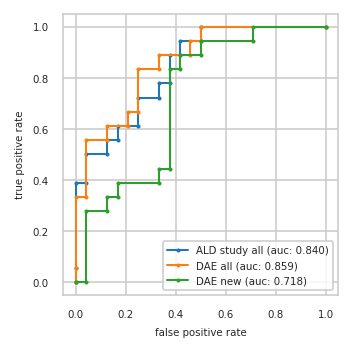

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.389   0.000 0.333   0.042 0.278
3          0.042 0.389   0.042 0.333   0.125 0.278
4          0.042 0.500   0.042 0.556   0.125 0.333
5          0.125 0.500   0.125 0.556   0.167 0.333
6          0.125 0.556   0.125 0.611   0.167 0.389
7          0.167 0.556   0.208 0.611   0.333 0.389
8          0.167 0.611   0.208 0.667   0.333 0.444
9          0.250 0.611   0.250 0.667   0.375 0.444
10         0.250 0.722   0.250 0.833   0.375 0.833
11         0.333 0.722   0.333 0.833   0.417 0.833
12         0.333 0.778   0.333 0.889   0.417 0.889
13         0.375 0.778   0.458 0.889   0.500 0.889
14         0.375 0.889   0.458 0.944   0.500 0.944
15         0.417 0.889   0.500 0.944   0.708 0.944
16         0.417 0.944   0.500 1.000   0.708 1.000
17         0.500 0.944   1.000 1.000   1.000 1.000
18         0.500 1.000     NaN   NaN     NaN   NaN
19         1.000 1.000     NaN   NaN     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NCL4,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2,B7Z5R6;Q14596;Q14596-2
2,O76061,D3YTG3;H0Y897;Q7Z7G0;Q7Z7G0-2;Q7Z7G0-3;Q7Z7G0-4,J3KSJ8;Q9UD71;Q9UD71-2
3,A0A0A0MRJ7;P12259,Q14894,P10644;P10644-2
4,P61981,P63104,P31321
5,P14174,Q9Y2T3;Q9Y2T3-3,P51688
6,P04075,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,C9JF17;P05090,P14174,E9PK25;G3V1A4;P23528
8,P00338;P00338-3,P00492,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


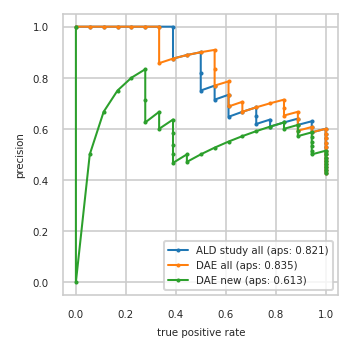

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.567 0.944
13         0.586 0.944     0.586 0.944     0.586 0.944
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.593 0.889     0.593 0.889
16         0.615 0.889     0.615 0.889     0.615 0.889
17         0.640 0.889     0.640 0.889     0.600 0.833
18         0.625 0.833     0.667 0.889     0.625 0.833
19         0.609 0.778     0.652 0.833     0.609 0.778
20         0.636 0.778     0.682 0.833     0.591 0.722
21         0.619 0.722     0.714 0.833     0.571 0.667
22         0.650 0.722     0.700 0.778     0.550 0.611
23         0.684 0.722     0.684 0.722     0.526 0.556
24         0.667 0.667     0.667 0.667     0.500 0.500
25         0.647 0.611     0.706 0.667     0.471 0.444
26         0.688 0.611     0.688 0.611     0.500 0.444
27         0.733 0.611     0.733 0.611     0.467 0.389
28         0.714 0.556     0.786 0.611     0.500 0.389
29         0.769 0.556     0.769 0.556     0.538 0.389
30         0.750 0.500     0.833 0.556     0.583 0.389
31         0.818 0.500     0.909 0.556     0.636 0.389
32         0.900 0.500     0.900 0.500     0.600 0.333
33         0.889 0.444     0.889 0.444     0.667 0.333
34         0.875 0.389     0.875 0.389     0.625 0.278
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     1.000 0.333     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


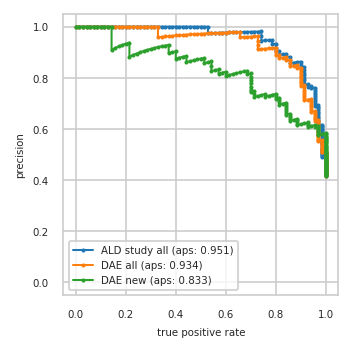

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


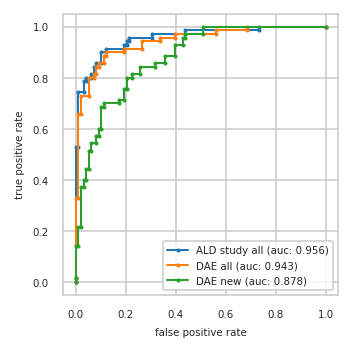

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}